<a href="https://colab.research.google.com/github/alt159/public_works/blob/main/PBI_Prediccion2BCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
import numpy as np
import itertools
from IPython.display import Image, display


Lo siguiente se podría hacer más elegante con un (pero son 4.34am):
```
/content/drive/MyDrive/HISTORICO/@BCP/Modelos_macro_FWL
```



### Carga de datos

Los datos del Producto Bruto Interno (PBI) se cargan desde un archivo Excel. La columna 'fecha' se establece como índice del DF y se renombra la columna del PBI a PBI. La idea sería llegar a tener un modelo que contemple la mayoría de estas etapas.

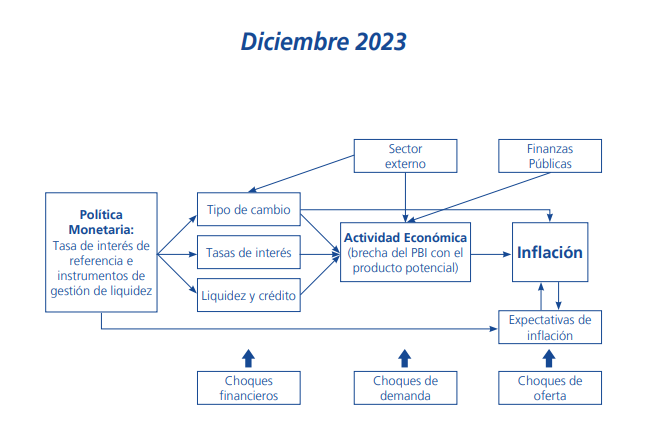

In [5]:
ruta_imagen = '/content/drive/MyDrive/HISTORICO/@BCP/Modelos_macro_FWL/Modelo económico peruano.png'
display(Image(filename=ruta_imagen))

In [3]:

data = pd.read_excel('/content/drive/MyDrive/HISTORICO/@BCP/Modelos_macro_FWL/pbi mes.xlsx')
data.set_index('fecha', inplace=True)
data.rename(columns={'Producto bruto interno y demanda interna (variaciones porcentuales anualizadas) - PBI': 'PBI'}, inplace=True)
data.head()


,PBI
fecha,
2004-01-01,3.674966
2004-02-01,4.245959
2004-03-01,5.774257
2004-04-01,4.247995
2004-05-01,3.950757


### Descomposición de la serie temporal

Vamos a descomponer  la serie temporal para identificar sus componentes de tendencia, estacionalidad y residuos. La idea es entender la dinámica subyacente de los datos del PBI y determinar la selección del modelo de predicción adecuado.

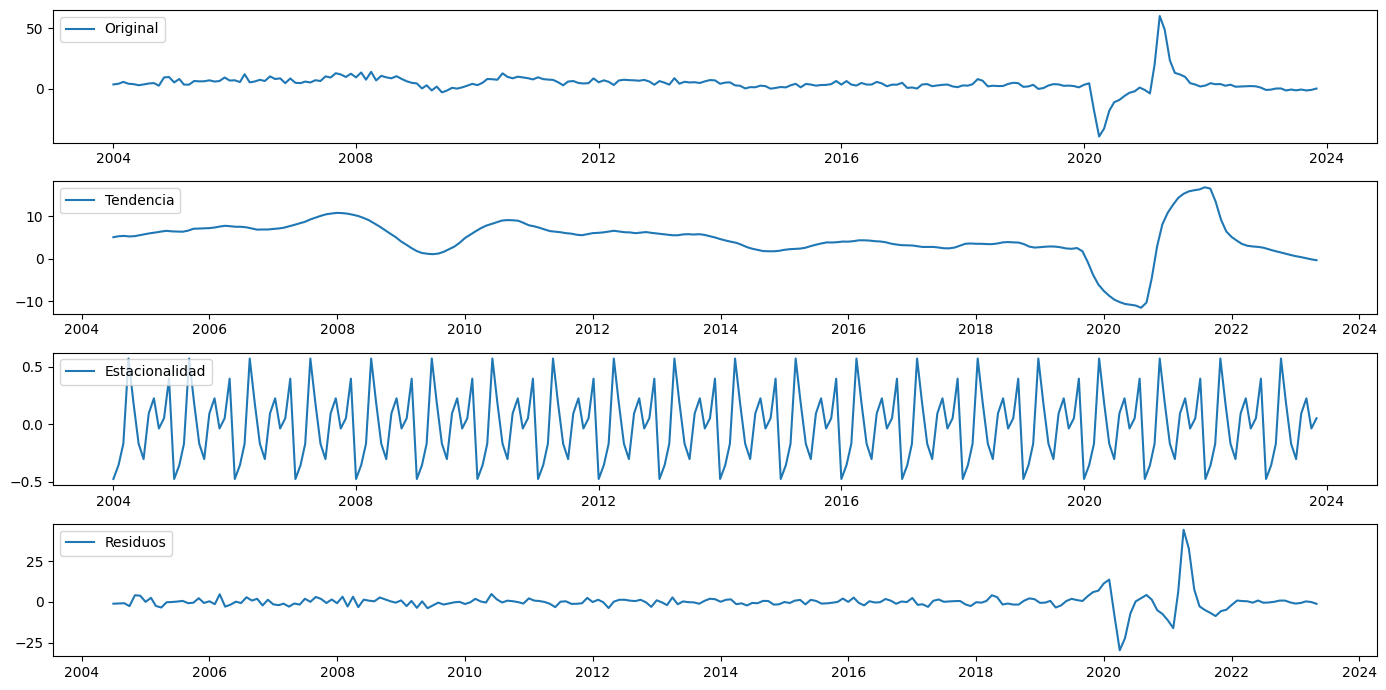

In [7]:

decomposicion = seasonal_decompose(data['PBI'], model='additive', period=12)

plt.figure(figsize=(14, 7))
plt.subplot(411)
plt.plot(data['PBI'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposicion.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposicion.seasonal,label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposicion.resid, label='Residuos')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

# no me gusta el color, luego busco la opción

### Análisis sintetizado

- ***Tendencia***: Se observa una tendencia a lo largo del tiempo, indicando cambios sistemáticos en el nivel del PBI.
- ***Estacionalidad***: Existen patrones estacionales claros, lo cual es esperado en series temporales económicas debido a factores como ciclos de negocios, campañas festivas, entre otras.
- ***Residuos***: Los residuos representan la parte de los datos que no se explica por la tendencia o la estacionalidad.

Dado que la serie temporal muestra tanto tendencia como estacionalidad, procederé a implementar y ajustar un modelo SARIMA para realizar las predicciones de los próximos 12 meses

In [8]:

p = d = q = range(0, 2)  # AR(p), Diferencias(d), MA(q) Orden de la media móvil
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in itertools.product(p, d, q):
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data['PBI'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

best_aic, best_pdq, best_seasonal_pdq


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

(1241.68067596176, (1, 0, 1), (1, 1, 1, 12))

### Resultados tras la convergencia

El algoritmo converge por lo que el mejor conjunto de parámetros encontrado para el modelo SARIMA, basado en el criterio de información AIC más bajo, es:

#### Convergencia

AIC: 1241.68067596176

#### Parámetros ARIMA:
(1,0,1)

Esto indica que el modelo que combina un término autorregresivo de primer orden con un término de media móvil de primer orden y no requiere trabajar en diferencias para hacer la serie estacionaria. Este modelo utiliza tanto la dependencia entre observaciones consecutivas como la dependencia entre los errores de predicción para modelar y predecir la serie temporal

### Parámetros estacionales:
(1,1,1,12)

Esto significa que el mejor modelo incluye un término autorregresivo de primer orden, un término de media móvil de primer orden, una diferenciación estacional de primer orden, y términos autorregresivos y de media móvil estacionales de primer orden con una periodicidad de 12 meses.


### Implementación

Utilizando el modelo SARIMA, se generan predicciones para los próximos 12 meses del PBI. El objetivo es visualizar tanto los datos históricos como las predicciones futuras, ofreciendo una perspectiva sobre la posible evolución del PBI en el corto plazo.

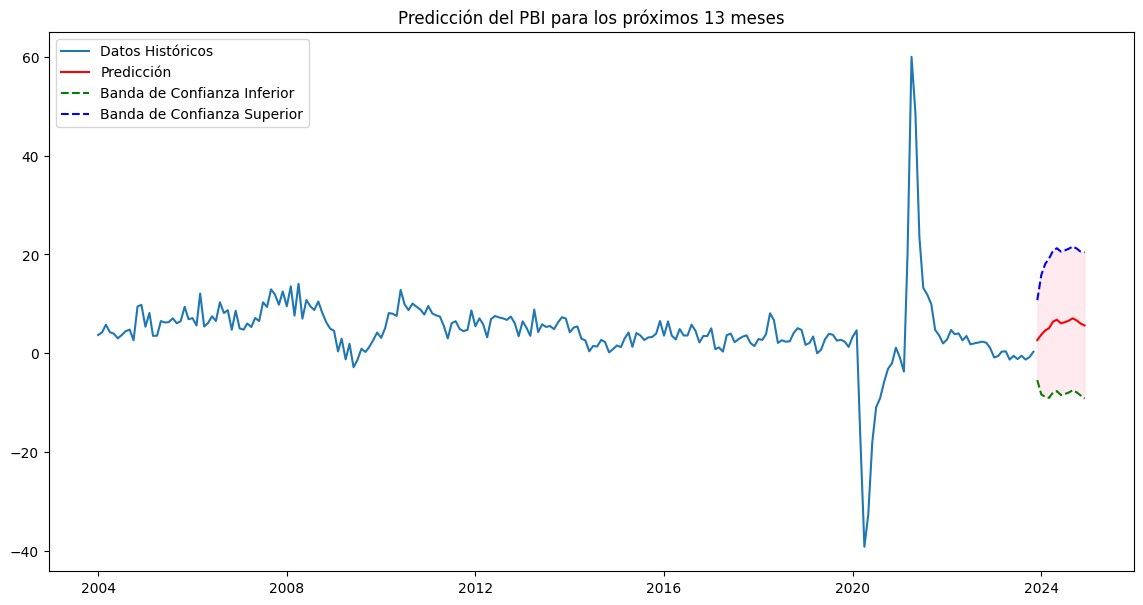

In [26]:
# Generar el forecast
future_dates = [data.index[-1] + DateOffset(months=x) for x in range(1, 14)]

# Forecast de los próximos 13 meses
forecast = best_model.get_forecast(steps=13)
forecast_index = pd.DatetimeIndex(future_dates)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# DataFrame con las predicciones
forecast_df = pd.DataFrame({'Fecha': forecast_index, 'Predicción PBI': forecast_mean.values})
forecast_df.set_index('Fecha', inplace=True)

# Gráfico de las predicciones
plt.figure(figsize=(14, 7))
plt.plot(data['PBI'], label='Datos Históricos')
plt.plot(forecast_df['Predicción PBI'], label='Predicción', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)

# Añadir las bandas de confianza
plt.plot(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], color='green', linestyle='--', label='Banda de Confianza Inferior')
plt.plot(forecast_conf_int.index, forecast_conf_int.iloc[:, 1], color='blue', linestyle='--', label='Banda de Confianza Superior')

plt.legend(loc='upper left')
plt.title('Predicción del PBI para los próximos 13 meses')
plt.show()


In [22]:
forecast_df.tail(2)

,Predicción PBI
Fecha,
2024-11-01,5.996958
2024-12-01,5.613873


### Validemos

Lo que haré contra el reporte de inflación del BCRP

In [30]:
# Seleccionar los últimos 12 datos de las predicciones
ultimos_12_datos = forecast_df['Predicción PBI'][-12:]

# Calcular la media
media = ultimos_12_datos.mean()
media

5.901384581185994

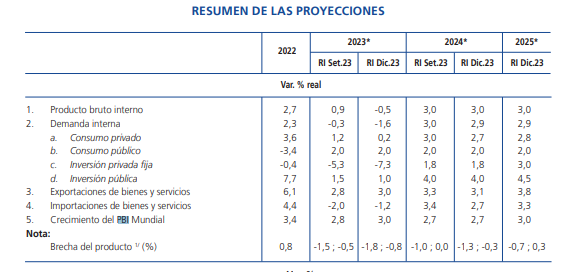

In [24]:
ruta_imagen = '/content/drive/MyDrive/HISTORICO/@BCP/Modelos_macro_FWL/proyecciones.png'
display(Image(filename=ruta_imagen))

La proyección del PBI elaborada por el BCRP para el 2024 y 2025 es de 3%, tanto para los reportes de inflación de set 23, dic23, lo que nos indica que se está prediciendo directamente la media anual para estos dos años. Se asume que esto se debe a que está tomando en cuenta el modelo teórico mostrado al inicio de este notebook completo o casi completo.

Además, en este modelo no se hace el trabajo -que asumo deben haber hecho en el BCRP- de suavizar los valores pre y post pandemia (que en abril del 2021 llega a valores del orden del 60%) probablemente con imputaciones de proyecciones de los años previos, sin embargo, 5 está dentro de las bandas de confianza y que las proyecciones que necesitamos son mensuales, las mismas que son:

In [32]:
# Crear un DataFrame con las bandas de confianza
bandas_confianza_df_corrected = pd.DataFrame(forecast_conf_int, columns=['lower PBI', 'upper PBI'])
bandas_confianza_df_corrected

,lower PBI,upper PBI
2023-12-01,-5.462413,10.743073
2024-01-01,-8.357182,15.838298
2024-02-01,-8.899485,18.130088
2024-03-01,-9.046241,19.168569
2024-04-01,-7.969989,20.763375
2024-05-01,-7.700596,21.263579
2024-06-01,-8.480034,20.587565
2024-07-01,-8.285441,20.828514
2024-08-01,-7.971266,21.163189
2024-09-01,-7.517701,21.625143


### Trabajo futuro para un modelo FWL en ***mayúsculas***

- Hacer lo propio para modelos de los otros componentes del modelo productivo conceptual macro del BCRP, o al menos para los componentes principales.
- Combinar las series de los modelos predichos para tener un único modelo FWL o usar las series directamente con proyecciones de PD para hacer modelos "calibrados" que sean FWL en ***mayúsculas***.
- Ubicar a un validador que conozca de modelos macroeconométricos que rete el modelo presentado.
- Recibir feedback y socializar con los stakeholders para ver si esto cumple las expectativas de un modelo FWL en ***mayúsculas***.


Nota: modelo realizado en 2 horas y 35 minutos, no pude llegar a 1 hora y media 🤐